# <span style="color:darkorange"> Exercises 10 (NSL) </span>
# <span style="color:darkorange"> 10.1: TSP - Parallel Search </span>

The goal of this exercise is to solve the TSP problem for the <font color="darkorange">U.S. state-capitals</font>, whose longitude and latitude coordinates are listed in file `American_capitals.dat`, with the leveraging of parallel computation. 

<font color="darkorange">Parallelization</font> basically means that the workload is shared among different computing elements that collaborate on the task completion. The scheme followed here for achieving parallel execution is the <font color="darkorange">Single Program Multiple Data model</font>. The <a href="https://docs.open-mpi.org/en/v5.0.x/index.html"> <font color="darkorange">Message Passing Interface (MPI)</font> </a> libraries take care of regulating communication between processes. 

___________________________________________


## Serial code

For the sake of comparison, before illustrating the parallelized code, it is reasonable to attempt a solution, by using the simpler <font color="darkorange">completely serial counterpart</font> of the code, in order to monitor any improvement, both time-wise and performance-wise.

Best path after 100 generations of 4000 individuals:	L^1 = 272.196
Best path after 500 generations of 4000 individuals:	L^1 = 269.646
Time elapsed:						T   = 37.6 seconds


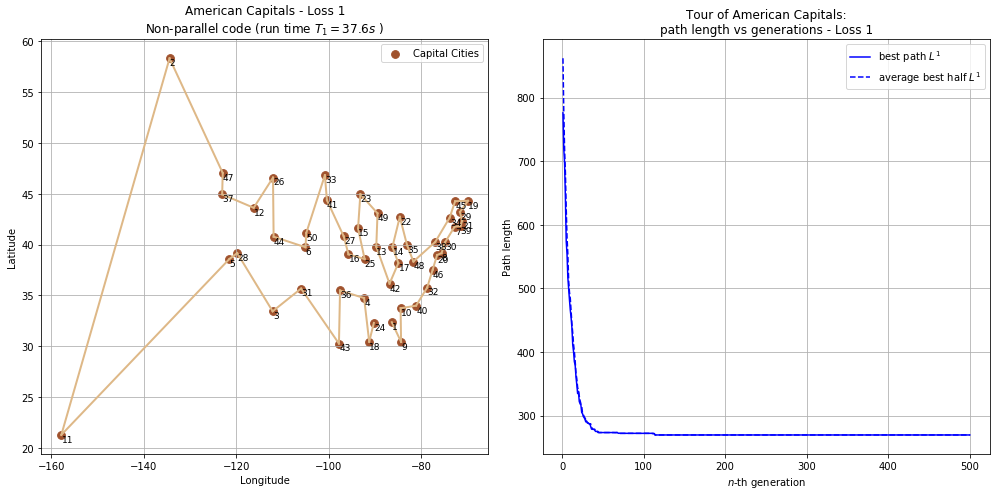

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Metric used
select_LOSS=1
# Run time
time = 37.6

# Figure setup
plt.figure(figsize=(14, 7))

########################## PART 1: American capitals with connections ##########################
# 1: Subplot 1: American capitals with connections
plt.subplot(1, 2, 1)
# 2: Read positions from file
with open('American_capitals.dat', 'r') as file:
    data_lines = file.readlines()
# 3: Extract longitude and latitude
x_points = []
y_points = []
for line in data_lines[1:]:
    fields = re.split(r'\s+', line.strip())
    x_points.append(float(fields[-2]))
    y_points.append(float(fields[-1]))
# 4: Draw cities
plt.scatter(x_points, y_points, color='sienna', s=60, label='Capital Cities')
for i, (x, y) in enumerate(zip(x_points, y_points), 1):
    plt.text(x + 0.03, y - 0.01, str(i), fontsize=9, ha='left', va='top')  # offset for label position
# 5: Read sequence from file and connect cities
sequence_file = f'NOT_PARALLEL/NORMAL_bestpath_loss{select_LOSS}.dat'
sequence = np.loadtxt(sequence_file, dtype=int)
for i in range(len(sequence) - 1):  # Loop until second to last city
    start_idx = sequence[i] - 1
    end_idx = sequence[i + 1] - 1
    plt.plot([x_points[start_idx], x_points[end_idx]], [y_points[start_idx], y_points[end_idx]], linewidth=2, color='burlywood')
plt.title(f'American Capitals - Loss {select_LOSS}\nNon-parallel code (run time $T_1 = {time} s$ )')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# 6: Finish plot
plt.legend()
plt.grid(True)

########################## PART 2: Path length vs generations ##########################
# 1: Subplot 2: Path length vs generations
plt.subplot(1, 2, 2)
# 2: Read data from file
data_file_1 = "NOT_PARALLEL/NORMAL_decrease50loss1.dat"
generations_1, best_path_1, average_best_half_1 = [], [], []
with open(data_file_1, 'r') as file:
    for line in file:
        values = line.split()
        generations_1.append(int(values[0]))
        best_path_1.append(float(values[1]))
        average_best_half_1.append(float(values[2]))
# 3: Plot the data
plt.plot(generations_1, best_path_1, '-', color='blue', label='best path $L^1$')
plt.plot(generations_1, average_best_half_1, '--', color='blue', label='average best half $L^1$')
plt.xlabel('$n$-th generation')
plt.ylabel('Path length')
#plt.ylim(260,800)
#plt.yscale('log')
plt.title('Tour of American Capitals:\npath length vs generations - Loss 1')
plt.grid()
plt.legend()
print(f'Best path after 100 generations of 4000 individuals:\tL^1 = {best_path_1[99]}')
print(f'Best path after 500 generations of 4000 individuals:\tL^1 = {best_path_1[-1]}')
print(f'Time elapsed:\t\t\t\t\t\tT   = {time} seconds')

########################### 
plt.tight_layout()
plt.show()

___________________________________________

# <span style="color:darkorange"> 10.2: Effectiveness of Migrations </span>

To perform a faster and possibly more accurate search over the possible paths, many parallel genetic searches are run simultaneously: the command

`mpiexec -np <number of processors> ./parallel.exe` 

invokes the <font color="darkorange">use of multiple processors</font> that cooperate to find the optimal path. 

The searches, called also <font color="darkorange">*continents*</font>, can either be completely <font color="darkorange">stand-alone</font> or they can <font color="darkorange">interact</font> via the MPI in order to exchange information. In particular, to make migrations happen, the code `parallel.cpp` calls the function:

`int MPI_Allgather(const void *sendbuf, int sendcount, MPI_Datatype sendtype,
                         void *recvbuf, int recvcount, MPI_Datatype recvtype,
                         MPI_Comm comm) `,
                         
that gathers data from all tasks and then distributes the combined data back to all tasks.

A migration consists in <font color="darkorange">randomly picking</font> a certain number of individuals from the population of a continent, identified by an integer called *rank*, copying them in a <font color="darkorange">buffer</font>, i.e. a region of memory used to store data temporarily, and then <font color="darkorange">distributing back</font> to each continent the individuals coming from continents different from itself. Lastly, the populations are sorted and resized, so that the least fit individuals are dismissed.

In addition, processes should be properly <font color="darkorange">synchronized</font> whenever information is exchanged.
However, <a href="https://www.mpich.org/static/docs/latest/www3/MPI_Allgather.html">MPI_Allgather</a> itself is a collective communication operation that <a href="https://rookiehpc.org/mpi/docs/mpi_iallgather/index.html"> <font color="darkorange"> inherently synchronizes</font></a> processes involved in the communication.


The best-performing parameters are found to be: 

|        genetic algorithm parameters         |        value in run card         |
| ------------------------------------------: | :------------------------------: |
| number of processors                        |                              $4$ |
| population size per processor               |                           $1000$ |
| loss function in use                        |                              $1$ |
| pair permutation probability                |                           $15\%$ |
| shift probability                           |                           $10\%$ |
| group permutation probability               |                            $5\%$ |
| inversion probability                       |                           $10\%$ |
| crossover probability                       |                           $99\%$ |
| number of generations                       |                            $500$ |
| interval between migrations                 |                             $10$ |
| percentage of migrating individuals         |                           $99\%$ |           
            
With fixed number of computing cores, population per processor and number of generations, the <font color="darkorange">diversification introduced by migration</font> seems to enhance the overall performance, as shown by the plots of the path length as a function of the number of generations.

MIGRATIONS DISABLED - RANK 0
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 276.943
MIGRATIONS ENABLED - RANK 0
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 269.22

MIGRATIONS DISABLED - RANK 1
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 276.943
MIGRATIONS ENABLED - RANK 1
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 269.22

MIGRATIONS DISABLED - RANK 2
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 276.943
MIGRATIONS ENABLED - RANK 2
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 269.22

MIGRATIONS DISABLED - RANK 3
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 276.943
MIGRATIONS ENABLED - RANK 3
Best path after 500 generations of 4000 individuals, split among 4 processors:	L^1 = 269.22

Time elapsed:									T = 6.

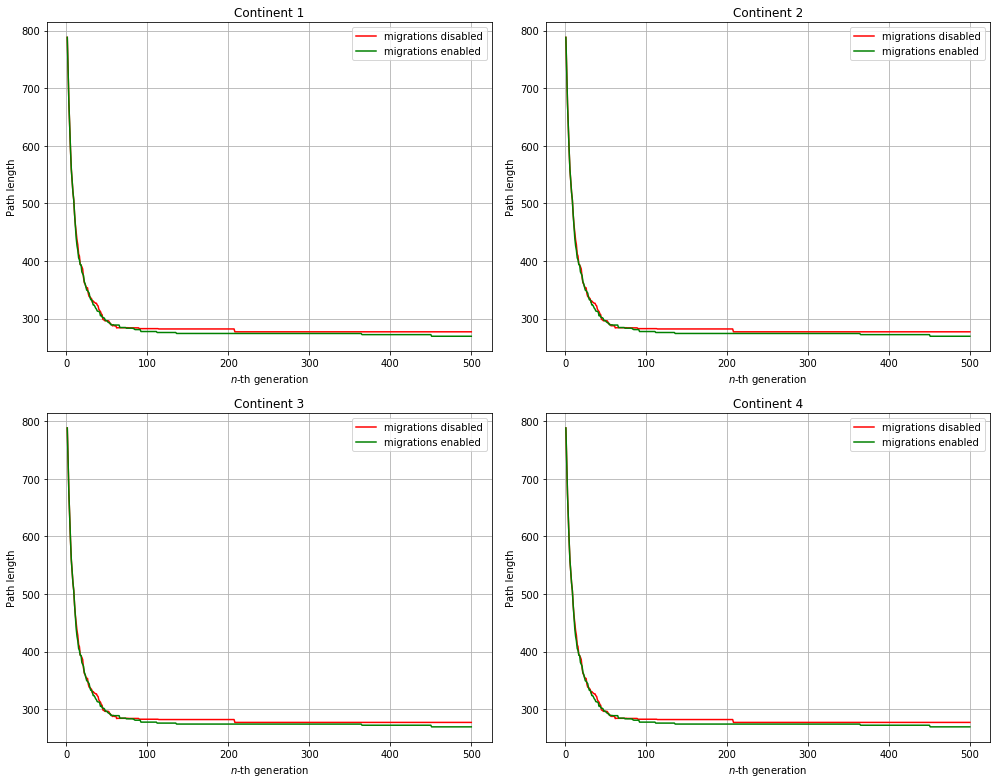

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# run time
time = 6.7

# best path length
best_route_NO_MIGR = []
best_route_MIGR_ENABLED = []

# figure setup
plt.figure(figsize=(14, 11))

# 1: create lists with filename in order to loop on them

file_NO_MIGR = ["migr0node0capitals50loss1.decrease","migr0node1capitals50loss1.decrease","migr0node2capitals50loss1.decrease","migr0node3capitals50loss1.decrease"]
file_MIGR_ENABLED = ["migr1node0capitals50loss1.decrease","migr1node1capitals50loss1.decrease","migr1node2capitals50loss1.decrease","migr1node3capitals50loss1.decrease"]

# 2: plot creation

for i_file in range(4):
    # 2.1: change subplot
    plt.subplot(2,2,i_file+1)
    # 2.2: auxiliary lists to store datasets
    generations, path_length_NO_MIGR, path_length_MIGR_ENABLED = [], [], []
    # 2.3: read files
    with open(file_NO_MIGR[i_file], 'r') as file:
        for line in file:
            values = line.split()
            generations.append(int(values[0]))
            path_length_NO_MIGR.append(float(values[1]))
    with open(file_MIGR_ENABLED[i_file], 'r') as file:
        for line in file:
            values = line.split()
            path_length_MIGR_ENABLED.append(float(values[1]))
    # 2.4: save best path length for each continent
    best_route_NO_MIGR.append(path_length_NO_MIGR[-1])
    best_route_MIGR_ENABLED.append(path_length_MIGR_ENABLED[-1])
    # 2.5: plot the two searches for comparison
    plt.plot(generations, path_length_NO_MIGR, '-', color='red', label='migrations disabled')
    plt.plot(generations, path_length_MIGR_ENABLED, '-', color='green', label='migrations enabled')
    plt.xlabel('$n$-th generation')
    plt.ylabel('Path length')
    plt.title(f'Continent {i_file+1}')
    plt.grid()
    plt.legend()
    
# 3: print results

for i_file in range(4):
    print(f'MIGRATIONS DISABLED - RANK {i_file}')
    print(f'Best path after 500 generations of 4000 individuals, split among 4 processors:\tL^1 = {best_route_NO_MIGR[i_file]}')
    print(f'MIGRATIONS ENABLED - RANK {i_file}')
    print(f'Best path after 500 generations of 4000 individuals, split among 4 processors:\tL^1 = {best_route_MIGR_ENABLED[i_file]}\n')

print(f'Time elapsed:\t\t\t\t\t\t\t\t\tT = {time} seconds')

# 4: show plots

plt.tight_layout()
plt.show()

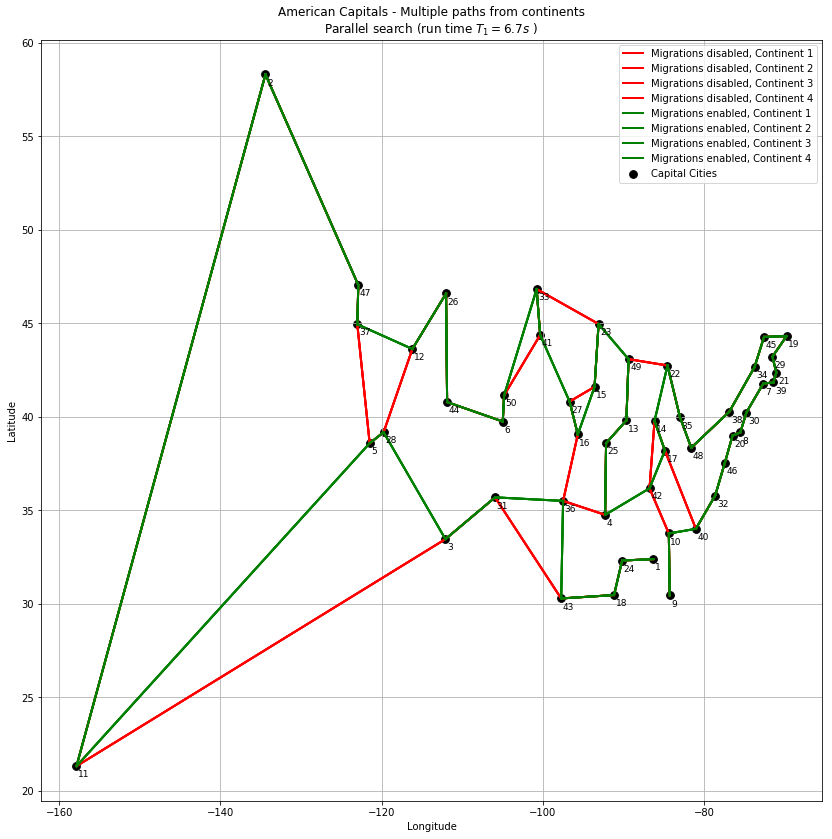

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

# run time
time = 6.7

########################## PART 1: Read American capitals positions ##########################

# 1: read American capitals positions from file
with open('American_capitals.dat', 'r') as file:
    data_lines = file.readlines()

# 2: extract longitude and latitude
x_points = []
y_points = []
for line in data_lines[1:]:
    fields = re.split(r'\s+', line.strip())
    x_points.append(float(fields[-2]))
    y_points.append(float(fields[-1]))

########################## PART 2: Set up the plot ##########################

# 3: create the figure and subplot
plt.figure(figsize=(14, 14))

# 4: draw cities
plt.scatter(x_points, y_points, color='k', s=60, label='Capital Cities')
for i, (x, y) in enumerate(zip(x_points, y_points), 1):
    plt.text(x + 0.2, y - 0.2, str(i), fontsize=9, ha='left', va='top')  # offset for label position

########################## PART 3: Plot paths based on different parameters ##########################

# 5: define parameters
number_of_cities = 50
which_loss = 1
colors = ['red', 'green']
labels = []

# 6: loop through different combinations of migrations_enabled and rank
for migrations_enabled in [0, 1]:
    for rank in range(4):
        # 6.1: create file name
        filename = f"migr{migrations_enabled}node{rank}capitals{number_of_cities}loss{which_loss}.bestpath"
        # 6.2: read sequence from file
        try:
            sequence = np.loadtxt(filename, dtype=int)
        except IOError:
            print(f"Could not read file: {filename}")
            continue
        # 6.3: plot the path
        label = f'Migrations {"enabled" if migrations_enabled else "disabled"}, Continent {rank + 1}'
        for i in range(len(sequence) - 1):
            start_idx = sequence[i] - 1
            end_idx = sequence[i + 1] - 1
            plt.plot([x_points[start_idx], x_points[end_idx]], [y_points[start_idx], y_points[end_idx]], linewidth=2, color=colors[migrations_enabled], label=label if i == 0 else "")
        
########################## PART 4: Finalize the plot ##########################

# 7: title and labels
plt.title(f'American Capitals - Multiple paths from continents\nParallel search (run time $T_1 = {time} s$ )')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 8: add legend
plt.legend()
plt.grid(True)

# 9: show plot
plt.show()
